<a href="https://www.kaggle.com/code/arieswang98/titanic-ml-02?scriptVersionId=113360954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd
import warnings

import seaborn as sns
import plotly
import plotly.express as px
from matplotlib import pyplot as plt
import scikitplot as skplt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

import pytorch_lightning as pl

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimizer

In [2]:
# Read data 
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

# basic info
print('\n'+'Some basic information about the train dataset'+'\n')
train.info()

print('\n'+'Some basic information about the test dataset'+'\n')
test.info()


Some basic information about the train dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Some basic information about the test dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  


In [3]:
# Feature engineering
## Proprecess data
train['Sex'].replace('male', 0 ,inplace= True)
train['Sex'].replace('female', 1 ,inplace= True)
train['Relation'] = train['SibSp']+train['Parch']
train['Ifhavekid'] = train['Parch']
train['Ifhavekid'][train['Ifhavekid']>0] = 1

dfresult = pd.DataFrame()
df = pd.get_dummies(train['Embarked'])
df.columns = ['Embarked_' +str(x) for x in df.columns ]
train = pd.concat([train,df],axis = 1)

train.Age = (train.Age-min(train.Age))/(max(train.Age)-min(train.Age))
train.Fare = (train.Fare-min(train.Fare))/(max(train.Fare)-min(train.Fare))

test['Sex'].replace('male', 0 ,inplace= True)
test['Sex'].replace('female', 1 ,inplace= True)
test['Relation'] = test['SibSp']+test['Parch']
test['Ifhavekid'] = test['Parch']
test['Ifhavekid'][test['Ifhavekid']>0] = 1

dfresult = pd.DataFrame()
df = pd.get_dummies(test['Embarked'])
df.columns = ['Embarked_' +str(x) for x in df.columns ]
test = pd.concat([test,df],axis = 1)

test.Age = (test.Age-min(test.Age))/(max(test.Age)-min(test.Age))
test.Fare = (test.Fare-min(test.Fare))/(max(test.Fare)-min(test.Fare))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
X = pd.concat([train['Pclass'],
               train['Sex'], train['Age'], train['SibSp'], train['Parch'],  
               train['Relation'], train['Fare']],axis=1)
for column in X:
    if np.any(X[column].isnull()):
        mean_val = np.mean(X[column])
        X[column].fillna(mean_val, inplace=True)

y = train['Survived']

In [5]:
X.describe()

,Pclass,Sex,Age,SibSp,Parch,Relation,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,0.367921,0.523008,0.381594,0.904602,0.062858
std,0.836071,0.477990,0.163383,1.102743,0.806057,1.613459,0.096995
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.271174,0.000000,0.000000,0.000000,0.015440
50%,3.000000,0.000000,0.367921,0.000000,0.000000,0.000000,0.028213
75%,3.000000,1.000000,0.434531,1.000000,0.000000,1.000000,0.060508
max,3.000000,1.000000,1.000000,8.000000,6.000000,10.000000,1.000000


In [ ]:
# reference：https://blog.csdn.net/yuekangwei/article/details/110310970
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import torch.nn.functional as Fun

# 数据准备
X = np.array(X)
y = np.array(y)
input=torch.FloatTensor(X)
label=torch.LongTensor(y)

# 定义BP神经网络
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 定义隐藏层网络
        self.out = torch.nn.Linear(n_hidden, n_output)   # 定义输出层网络

    def forward(self, x):
        x = Fun.relu(self.hidden(x))      # 隐藏层的激活函数
        x = self.out(x)                   # 输出层不用激活函数
        return x

# 定义优化器损失函数
net = Net(n_feature=7, n_hidden=200, n_output=2)    #n_feature:输入的特征维度,n_hiddenb:神经元个数,n_output:输出的类别个数
optimizer = torch.optim.SGD(net.parameters(), lr=0.07) # 优化器选用随机梯度下降方式
loss_func = torch.nn.CrossEntropyLoss() # 对于多分类一般采用的交叉熵损失函数,

In [43]:
# reference：https://blog.csdn.net/yuekangwei/article/details/110310970
# network 2
import numpy as np
import torch
import torch.nn as nn
from collections import Counter
import torch.nn.functional as F

# 数据准备
X = np.array(X)
y = np.array(y)
input=torch.FloatTensor(X)
label=torch.LongTensor(y)

# 定义BP神经网络
class Net(torch.nn.Module):
    def __init__(self, n_output):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 256)
        self.fc2 = nn.Linear(256, 128)  
        self.fc3 = nn.Linear(128, 64)  
        self.fc4 = nn.Linear(64, 16)  
        self.out = nn.Linear(16,  n_output) 

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

# 定义优化器损失函数
net = Net(n_output=2)    #n_feature:输入的特征维度,n_hiddenb:神经元个数,n_output:输出的类别个数
optimizer = torch.optim.SGD(net.parameters(), lr=0.05) # 优化器选用随机梯度下降方式
loss_func = torch.nn.CrossEntropyLoss() # 对于多分类一般采用的交叉熵损失函数,

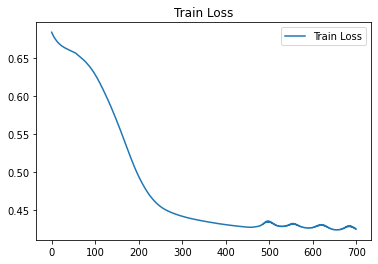

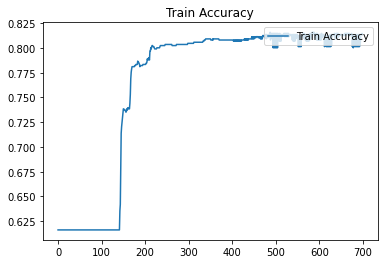

预测准确率 0.8170594837261503


In [44]:
# 训练数据
trainloss = []
trainacc = []
for t in range(700):
    out = net(input)                 # 输入input,输出out
    loss = loss_func(out, label)     # 输出与label对比
    
    trainloss.append(loss.item())
    
    prediction = torch.max(out, 1)[1] # 返回index  0返回原值
    pred_y = prediction.data.numpy()
    target_y = label.data.numpy()
    accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
    trainacc.append(accuracy)
    
    optimizer.zero_grad()   # 梯度清零
    loss.backward()         # 前馈操作
    optimizer.step()        # 使用梯度优化器


# 绘制训练过程
plt.title('Train Loss')
plt.plot(np.arange(len(trainloss)), trainloss)
plt.legend(['Train Loss'], loc='upper right')
plt.show()

plt.title('Train Accuracy')
plt.plot(np.arange(len(trainacc)), trainacc)
plt.legend(['Train Accuracy'], loc='upper right')
plt.show()

# 得出结果
out = net(input) #out是一个计算矩阵，可以用Fun.softmax(out)转化为概率矩阵
prediction = torch.max(out, 1)[1] # 返回index  0返回原值
pred_y = prediction.data.numpy()
target_y = label.data.numpy()

# 衡量准确率
accuracy = float((pred_y == target_y).astype(int).sum()) / float(target_y.size)
print("预测准确率",accuracy)

In [35]:
# Predict
data_to_pred = pd.concat([test['Pclass'], test['Sex'], test['Age'], 
                          test['SibSp'], test['Parch'], test['Relation'], 
                          test['Fare']],axis=1)
for column in data_to_pred:
    if np.any(data_to_pred[column].isnull()):
        mean_val = np.mean(data_to_pred[column])
        data_to_pred[column].fillna(mean_val, inplace=True)

data_to_pred = np.array(data_to_pred)
input = torch.FloatTensor(data_to_pred)
out = net(input) #out是一个计算矩阵，可以用Fun.softmax(out)转化为概率矩阵
prediction = torch.max(out, 1)[1] # 返回index  0返回原值
pred_y = prediction.data.numpy()

res = pd.concat([test['PassengerId'], pd.Series(pred_y)], axis=1)
res.columns = ['PassengerId', 'Survived']
res.to_csv('/kaggle/working/submission.csv', index=False)
print('over')

over
